# Import Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
import math
from tensorflow.keras import backend as K

import pickle
from sklearn.metrics import *

# Load Data

In [3]:
with open('drive/MyDrive/agora/agora_hack_products.json', 'r') as f:
    text = f.read()

In [21]:
data = json.loads(text)

In [22]:
for i in range(len(data)):
    data[i]['props'] = [x.replace('\t', ' ') for x in data[i]['props']]

In [24]:
product_id = []
name = []
is_reference = []
reference_id = []
props = []

for d in data:
    product_id.append(d['product_id'])
    name.append(d['name'])
    is_reference.append(d['is_reference'])
    reference_id.append(d['reference_id'])
    props.append(d['props'])

dataset = pd.DataFrame()
dataset['product_id'] = product_id
dataset['name'] = name
dataset['is_reference'] = is_reference
dataset['reference_id'] = reference_id
dataset['props'] = props

In [25]:
dataset.loc[~dataset.is_reference, 'target'] = dataset.loc[~dataset.is_reference, 'reference_id']
dataset.loc[dataset.is_reference, 'target'] = dataset.loc[dataset.is_reference, 'product_id']

In [26]:
target_map = {k: v for v, k in enumerate(dataset.target.unique())}

In [27]:
dataset.target = dataset.target.map(target_map)

In [28]:
index_train, index_val = train_test_split(dataset.index.values, 
                                          test_size=0.15, 
                                          stratify=dataset.target.values)

# EDA

In [ ]:
len(data)

3251

In [ ]:
data[0].keys()

dict_keys(['product_id', 'name', 'props', 'is_reference', 'reference_id'])

In [ ]:
for d in data:
    if d['reference_id']:
        break

In [ ]:
d

{'product_id': '0007302f2fe1d54d',
 'name': 'Классическая сплит-система ROYAL CLIMA PANDORA RC-PD28HN, для комнат до 28 кв.метра, настенный кондиционер для дома/офиса, комплект',
 'props': ['Класс  энергоэффективности\tA',
  'Мощность  кондиционера\t9 BTU',
  'Уровень  шума внутреннего блока\t21.5 дБ - 38 дБ',
  'Режим   работы\tохлаждение / обогрев',
  'Фильтр тонкой очистки\tесть',
  'Доп.   режимы турбо, экорежим, осушение, ночной, вентиляция'],
 'is_reference': False,
 'reference_id': 'f497219eb0077f84'}

In [ ]:
for d in data:
    if d['product_id'] == 'f497219eb0077f84':
        break

In [ ]:
d

{'product_id': 'f497219eb0077f84',
 'name': 'Сплит-система Royal Clima RC-PD28HN, белый',
 'props': ['Линейка\tPANDORA',
  'Площадь помещения\t28 м²',
  'Режим работы\tохлаждение / обогрев',
  'Мощность   кондиционера\t9 BTU',
  'Фильтр   тонкой очистки\tесть',
  'Мощность   охлаждения\t2750 Вт / обогрева: 2950 Вт',
  'Класс   энергоэффективности\tA',
  'Уровень  шума внутреннего блока\t21.5 дБ - 38 дБ',
  'Доп.  режимы экорежим, осушение, ночной, вентиляция, турбо',
  'Фильтры   с ионами серебра, дезодорирующий',
  'Особенности  дисплей, таймер включения/выключения, пульт ДУ, регулировка направления воздушного потока, индикация работы'],
 'is_reference': True,
 'reference_id': None}

In [ ]:
d['name']

'Сплит-система Royal Clima RC-PD28HN, белый'

In [ ]:
[x.split('\t') for x in d['props']]

[['Линейка', 'PANDORA'],
 ['Площадь помещения', '28 м²'],
 ['Режим работы', 'охлаждение / обогрев'],
 ['Мощность   кондиционера', '9 BTU'],
 ['Фильтр   тонкой очистки', 'есть'],
 ['Мощность   охлаждения', '2750 Вт / обогрева: 2950 Вт'],
 ['Класс   энергоэффективности', 'A'],
 ['Уровень  шума внутреннего блока', '21.5 дБ - 38 дБ'],
 ['Доп.  режимы экорежим, осушение, ночной, вентиляция, турбо'],
 ['Фильтры   с ионами серебра, дезодорирующий'],
 ['Особенности  дисплей, таймер включения/выключения, пульт ДУ, регулировка направления воздушного потока, индикация работы']]

In [ ]:
lens_refference = []
lens_products = []
for d in data:
    if d['is_reference']:
        lens_refference.append(len(d['props']))
    else:
        lens_products.append(len(d['props']))

In [ ]:
lens_refference = pd.Series(lens_refference)
lens_products = pd.Series(lens_products)

In [ ]:
lens_refference.describe()

count    471.000000
mean       9.027601
std        2.472246
min        3.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       16.000000
dtype: float64

In [ ]:
lens_products.describe()

count    2780.000000
mean        3.968705
std         2.411013
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        13.000000
dtype: float64

# TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
corpus = []

for d in tqdm(data):
    text = d['name'] + ' ; '
    for prop in d['props']:
        text += ': '.join(prop.split('\t')) + ' ; '
    corpus.append(text)

100%|██████████| 3251/3251 [00:00<00:00, 43011.11it/s]


In [ ]:
vectorizer = TfidfVectorizer()
tfidf_embeddings = vectorizer.fit_transform(corpus)

In [ ]:
tfidf_embeddings.shape

(3251, 4066)

# Fasttext Embeddings

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 4.0 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3168491 sha256=c3b9f41cf71679f6dacb8b5b93d4e9d1f629d8f90eb179f53d50549709b2b9c6
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import fasttext

# fasttext train on all texts
pd.DataFrame(corpus).to_csv('data_all.txt', header=None, index=None, sep='\t', mode='a')
ft_model = fasttext.train_unsupervised('data_all.txt')

In [ ]:
fasttext_embeddings = []

for text in tqdm(corpus):
    
    fasttext_embeddings.append(ft_model.get_sentence_vector(text))

100%|██████████| 3251/3251 [00:00<00:00, 4269.29it/s]


In [ ]:
fasttext_embeddings = np.array(fasttext_embeddings)

# Transformer Embeddings

## LaBSE

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from sentence_transformers import SentenceTransformer
labse_model = SentenceTransformer('LaBSE')

In [ ]:
labse_model.save('labse_model')

In [ ]:
corpus = []

for d in tqdm(data):
    text = d['name'] + ' ; '
    for prop in d['props']:
        text += ': '.join(prop.split('\t')) + ' ; '
    corpus.append(text)

100%|██████████| 3251/3251 [00:00<00:00, 97172.85it/s]


In [ ]:
labse_embeddings = labse_model.encode(corpus)

In [ ]:
labse_embeddings.shape

(3251, 768)

In [ ]:
%%time
labse_embeddings = labse_model.encode(corpus[:100])

CPU times: user 346 ms, sys: 10.1 ms, total: 356 ms
Wall time: 687 ms


## RuBert

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ruBert_model = SentenceTransformer('sberbank-ai/ruBert-base')
ruBert_embeddings = ruBert_model.encode(corpus)
ruBert_embeddings.shape

(3251, 768)

In [ ]:
DPruBert_model = SentenceTransformer('DeepPavlov/rubert-base-cased-conversational')
DPruBert_embeddings = DPruBert_model.encode(corpus)
DPruBert_embeddings.shape

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/941 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased-conversational were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(3251, 768)

In [ ]:
multilingbert_model = SentenceTransformer('bert-base-multilingual-uncased')
multilingbert_embeddings = multilingbert_model.encode(corpus)
multilingbert_embeddings.shape

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(3251, 768)

In [ ]:
miniLM_model = SentenceTransformer('all-MiniLM-L6-v2')
miniLM_embeddings = miniLM_model.encode(corpus)
miniLM_embeddings.shape

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

(3251, 384)

# ArcFace Loss

## Funcs

In [29]:
import tensorflow as tf
import math
from tensorflow.keras import backend as K

In [30]:
class config:
    SEED=17
    N_CLASSES = 471
    ARC_FACE_M = 0.3
    EMB_DIM = 1024
    head = 'arcface'
    LR = 1e-4
    BATCH_SIZE = 32
    EPOCHS = 100
    MODEL_NAME = 'ArcFaceModel'
    save_dir = 'models'

In [31]:
# Modified version of ArcFace from original kernel to create this. Based on paper ElasticFace: Elastic Margin Loss for Deep Face Recognition (https://arxiv.org/pdf/2109.09416.pdf).

class ElasticArcFace(tf.keras.layers.Layer):
    def __init__(
        self,
        n_classes,
        s=30,
        mean=0.50,
        std=0.025,
        easy_margin=False,
        ls_eps=0.0,
        **kwargs
    ):

        super(ElasticArcFace, self).__init__(**kwargs)
        
        print(f'ElasticArcFace mean: {mean}, s: {std}')

        self.n_classes = n_classes
        self.s = s
        self.mean = mean
        self.std = std
        self.ls_eps = ls_eps

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'mean': self.mean,
            'std': self.std,
            'ls_eps': self.ls_eps
        })
        return config

    def build(self, input_shape):
        super(ElasticArcFace, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))

        m = tf.random.normal((tf.shape(y)[0], 1), mean=self.mean, stddev=self.std, seed=config.SEED)

        cos_m = tf.math.cos(m)
        sin_m = tf.math.sin(m)
        th = tf.math.cos(math.pi - m)
        mm = tf.math.sin(math.pi - m) * m
        
        phi = cosine * cos_m - sine * sin_m

        phi = tf.where(cosine > th, phi, cosine - mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
            )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [32]:
def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

def get_model():    
    # with strategy.scope():
    margin = ElasticArcFace(
        n_classes = config.N_CLASSES, 
        s = 30, 
        mean = config.ARC_FACE_M,
        std=0.025,
        name=f'head/{config.head}', 
        dtype='float32'
    )
    inp = tf.keras.layers.Input(shape=[17, 768], name = 'inp1')
    label = tf.keras.layers.Input(shape=(), name = 'inp2')

    conv_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(1024, 3, activation='relu'),
        tf.keras.layers.Conv1D(2048, 3, activation='relu'),
        tf.keras.layers.Conv1D(1024, 3, activation='relu'),
    ])
    
    x = conv_model(inp)
    # Concat pooling
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
    pretrained_out = tf.keras.layers.Concatenate()([avg_pool, max_pool])
    
    print(f'Size of embed {config.EMB_DIM}')
    pre_margin_dense_layer = tf.keras.layers.Dense(config.EMB_DIM)

    # Multiple-sample dropout https://arxiv.org/abs/1905.09788
    dropout_base = 0.17
    drop_ls = [tf.keras.layers.Dropout((dropout_base + 0.01), seed=420),
               tf.keras.layers.Dropout((dropout_base + 0.02), seed=4200),
               tf.keras.layers.Dropout((dropout_base + 0.03), seed=42000),
               tf.keras.layers.Dropout((dropout_base + 0.04), seed=420000),
               tf.keras.layers.Dropout((dropout_base + 0.05), seed=4200000)]
    for ii, drop in enumerate(drop_ls):
        if ii == 0:
            embed = (pre_margin_dense_layer(drop(pretrained_out)) / 5.0)
        else:
            embed += (pre_margin_dense_layer(drop(pretrained_out)) / 5.0)
            
    embed = tf.keras.layers.BatchNormalization()(embed)
    embed = tf.math.l2_normalize(embed, axis=1)
    
    x = margin([embed, label])
    output = tf.keras.layers.Softmax(dtype='float32', name='metric_out')(x)
    
    model = tf.keras.models.Model(inputs = [inp, label], outputs=output)
    embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
    
    opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
    model.compile(
        optimizer = opt,
        loss={'metric_out': tf.keras.losses.SparseCategoricalCrossentropy()},
        metrics={'metric_out': [tf.keras.metrics.SparseCategoricalAccuracy(), 
                                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)]}
    ) 
    
    return model, embed_model

['0.00010000000000000000', '0.00032499999999999999', '0.00055000000000000003', '0.00077500000000000008', '0.00100000000000000002', '0.00090000999999999992', '0.00081001899999999993', '0.00072902709999999996', '0.00065613438999999991', '0.00059053095100000002', '0.00053148785589999994', '0.00047834907031000005', '0.00043052416327900008', '0.00038748174695110005', '0.00034874357225599009', '0.00031387921503039104', '0.00028250129352735200', '0.00025426116417461676', '0.00022884504775715512', '0.00020597054298143960', '0.00018538348868329564', '0.00016685513981496610', '0.00015017962583346948', '0.00013517166325012256', '0.00012166449692511029', '0.00010950804723259927', '0.00009856724250933934', '0.00008872051825840542', '0.00007985846643256487', '0.00007188261978930838', '0.00006470435781037755', '0.00005824392202933979', '0.00005242952982640582', '0.00004719657684376524', '0.00004248691915938872', '0.00003824822724344984', '0.00003443340451910486', '0.00003100006406719437', '0.00002791

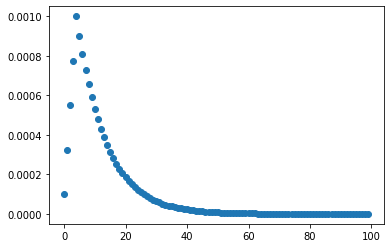

In [33]:
def get_lr_callback(plot=False):
    lr_start   = config.LR
    lr_max     = 10 * config.LR
    lr_min     = 1e-7
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        print([f'{i:.20f}' for i in learning_rates])
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

lr_callback = get_lr_callback(plot=True)

## Data

In [34]:
labse_arc_embeddings = []

for d in tqdm(data):
    # labse_embedding = np.zeros((17, 768))
    # labse_embedding[0, :] = labse_model.encode(d['name'])
    # for i, prop in enumerate(d['props']):
    #     labse_embedding[i+1, :] = labse_model.encode(prop)

    labse_embedding = np.zeros((17, 768))
    corpus = [d['name']]
    for prop in d['props']:
        corpus.append(prop)
    corpus_embedding = np.array(labse_model.encode(corpus))
    labse_embedding[:corpus_embedding.shape[0], :] = corpus_embedding
    
    labse_arc_embeddings.append(labse_embedding)

100%|██████████| 3251/3251 [01:12<00:00, 44.77it/s]


In [35]:
labse_arc_embeddings = np.array(labse_arc_embeddings)

In [36]:
X_train = labse_arc_embeddings[index_train]
X_val = labse_arc_embeddings[index_val]

y_train = dataset.target.values[index_train]
y_val = dataset.target.values[index_val]

In [37]:
X_train.shape

(2763, 17, 768)

In [38]:
y_train.shape

(2763,)

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(labse_arc_embeddings, dataset.target.values, 
#                                                   test_size=0.15, stratify=dataset.target.values)

In [39]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, 
                 embeddings,
                 labels,
                 augment=True,
                 batch_size=8,
                 shuffle=True):
        
        self.embeddings = embeddings
        self.labels = labels
        self.augment = augment
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.labels)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, embeddings, labels):
    
        X_batch = []
        y_batch = []
        
        for x, y in zip(embeddings, labels):

            X_batch.append(x)
            y_batch.append(y)

            for i in range(7):
                temp = x[1:, :]
                np.random.shuffle(temp)
                x[1:, :] = temp
                X_batch.append(x)
                y_batch.append(y)
            
        return np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.embeddings[i] for i in indexes],
                                [self.labels[i] for i in indexes])        
        
        return [X, y], y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.labels) / self.batch_size))

In [40]:
train_datagen = CustomDataGen(X_train, y_train)
val_datagen = CustomDataGen(X_val, y_val)

In [41]:
for x, y in train_datagen:
    break

print(x[0].shape)
print(x[1].shape)
print(y.shape)

(64, 17, 768)
(64,)
(64,)


## Fit

In [42]:
# STEPS_PER_EPOCH = len(X_train) // config.BATCH_SIZE

# # SAVE BEST MODEL       
# sv_loss = tf.keras.callbacks.ModelCheckpoint(
#     config.save_dir+f'{config.MODEL_NAME}_loss.h5',
#     monitor='val_loss',
#     verbose=0,
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     save_freq='epoch')

# BUILD MODEL
K.clear_session()
model, embed_model = get_model()
model.summary()

callbacks = [
    get_lr_callback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', mode='min', 
                                       filepath=config.save_dir+f'{config.MODEL_NAME}_best.h5', 
                                       verbose=1, save_best_only=True, save_weights_only=False)
]

ElasticArcFace mean: 0.3, s: 0.025
Size of embed 1024
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 17, 768)]    0           []                               
                                                                                                  
 sequential (Sequential)        (None, 11, 1024)     14946304    ['inp1[0][0]']                   
                                                                                                  
 global_average_pooling1d (Glob  (None, 1024)        0           ['sequential[0][0]']             
 alAveragePooling1D)                                                                              
                                                                                                  
 global_max_pooling1d (GlobalMa  (None, 

Epoch 1/100
345/345 [==============================] - ETA: 0s - loss: 14.3608 - sparse_categorical_accuracy: 5.4348e-04 - sparse_top_k_categorical_accuracy: 0.0019
Epoch 1: val_loss improved from inf to 13.71880, saving model to modelsArcFaceModel_best.h5
345/345 [==============================] - 25s 33ms/step - loss: 14.3608 - sparse_categorical_accuracy: 5.4348e-04 - sparse_top_k_categorical_accuracy: 0.0019 - val_loss: 13.7188 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 2.5615e-04 - lr: 1.0000e-04
Epoch 2/100
344/345 [============================>.] - ETA: 0s - loss: 13.3684 - sparse_categorical_accuracy: 0.0048 - sparse_top_k_categorical_accuracy: 0.0079
Epoch 2: val_loss improved from 13.71880 to 13.48988, saving model to modelsArcFaceModel_best.h5
345/345 [==============================] - 11s 32ms/step - loss: 13.3652 - sparse_categorical_accuracy: 0.0048 - sparse_top_k_categorical_accuracy: 0.0079 - val_loss: 13.4899 - val_sparse_cat

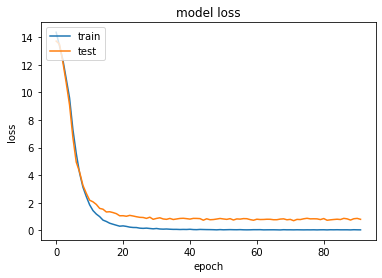

In [43]:
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=config.EPOCHS,
    callbacks=callbacks,
    verbose=1
)

try:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
except:
    pass

In [44]:
# 0.73255 0.8947
# 0.69593 0.9057

In [45]:
# !ls

In [ ]:
# model, _ = get_model()
# model.load_weights('drive/MyDrive/agora/ArcFaceModel_best.h5')
# embed_model = tf.keras.models.Model(inputs=model.input[0], 
#                                     outputs=model.get_layer('tf.math.l2_normalize').output)

ElasticArcFace mean: 0.3, s: 0.025
Size of embed 1024


In [46]:
model.load_weights('modelsArcFaceModel_best.h5')
embed_model = tf.keras.models.Model(inputs=model.input[0], 
                                    outputs=model.get_layer('tf.math.l2_normalize').output)

In [47]:
arc_embeddings = embed_model.predict(labse_arc_embeddings)

# KNN on Embeddings

In [48]:
# fasttext_embeddings
# tfidf_embeddings
# labse_embeddings
# arc_embeddings

In [49]:
from sklearn.neighbors import NearestNeighbors

In [50]:
db = dataset.loc[index_train].reset_index(drop=True)
test = dataset.loc[index_val].reset_index(drop=True)

In [51]:
# Для тестирования только на эталонах

# db = dataset.loc[index_train]
# db = db[db.is_reference]
# db_index = db.index.values
# db = db.reset_index(drop=True)

In [52]:
knn = NearestNeighbors(n_neighbors=1, metric='cosine')
knn.fit(arc_embeddings[index_train])
# knn.fit(arc_embeddings[db_index])

# pickle.dump(knn, open('knnpickle', 'wb'))
# knn = pickle.load(open('knnpickle', 'rb'))

NearestNeighbors(metric='cosine', n_neighbors=1)

In [53]:
dist, indx = knn.kneighbors(arc_embeddings[index_val], return_distance=True)

In [54]:
np.where(dist[:, 0] > 0.2)

(array([  0,   8,  19,  26,  64,  68,  83,  90,  96, 123, 133, 166, 192,
        206, 213, 218, 221, 227, 248, 256, 261, 267, 273, 277, 288, 312,
        321, 328, 383, 386, 387, 415, 421, 422, 426, 441, 444, 471, 472]),)

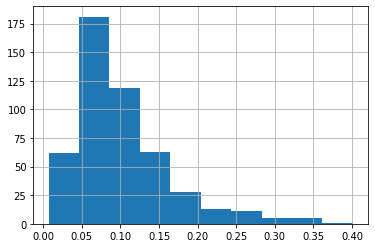

In [55]:
pd.Series(dist[:, 0]).hist()

In [56]:
dist[2]

array([0.05646026], dtype=float32)

In [57]:
db.loc[indx[2]]

,product_id,name,is_reference,reference_id,props,target
2572,d10843eb7b95b03b,"Фитнес-браслет Xiaomi Mi Smart Band 5, чер, BH...",False,729f1b1e59600803,"[Размер ремешка 155-219, Емкость аккумулятора ...",416


In [58]:
test.loc[2]

product_id                                       729f1b1e59600803
name            Умный браслет Xiaomi Mi Smart Band 5 Global, ч...
is_reference                                                 True
reference_id                                                 None
props           [Размер ремешка 155-219, Материал браслета/рем...
target                                                        416
Name: 2, dtype: object

In [59]:
val_preds = db.loc[indx[:, -1]].target.values

In [60]:
val_gt = test.target.values

In [61]:
accuracy_score(val_gt, val_preds)

0.9631147540983607

In [62]:
def knn_test(embeddings):
    knn = NearestNeighbors(n_neighbors=1, metric='cosine')
    knn.fit(embeddings[index_train])
    dist, indx = knn.kneighbors(embeddings[index_val], return_distance=True)
    val_preds = db.loc[indx[:, -1]].target.values
    val_gt = test.target.values
    print(accuracy_score(val_gt, val_preds))

In [63]:
# fasttext_embeddings
# tfidf_embeddings
# labse_embeddings
# arc_embeddings

In [65]:
# for embeddings in [
#     # DPruBert_embeddings, miniLM_embeddings,
#                 #    ruBert_embeddings, multilingbert_embeddings,
#                 #    tfidf_embeddings, 
#                    labse_embeddings, 
#                    arc_embeddings]:
#     knn_test(embeddings)

'drive/MyDrive/agora/ArcFaceModel_best.h5'

'drive/MyDrive/agora/labse_model'

In [67]:
knn = NearestNeighbors(n_neighbors=1, metric='cosine')
knn.fit(arc_embeddings)

pickle.dump(knn, open('knnpickle', 'wb'))
knn = pickle.load(open('knnpickle', 'rb'))

In [68]:
dataset.loc[~dataset.is_reference, 'reference_id'] = dataset.loc[~dataset.is_reference, 'reference_id']
dataset.loc[dataset.is_reference, 'reference_id'] = dataset.loc[dataset.is_reference, 'product_id']

In [69]:
np.save('reference_id_db', dataset.reference_id.values)

# Inference

In [93]:
# import shutil
# shutil.copy('modelsArcFaceModel_best.h5', 'drive/MyDrive/agora/ArcFaceModel_best.h5')
# shutil.copytree('labse_model', 'drive/MyDrive/agora/labse_model')
# shutil.copy('knnpickle', 'drive/MyDrive/agora/knnpickle')
# shutil.copy('reference_id_db.npy', 'drive/MyDrive/agora/reference_id_db.npy')

'drive/MyDrive/agora/ArcFaceModel_best.h5'

In [90]:
import tensorflow as tf
from sentence_transformers import SentenceTransformer

import pickle
import numpy as np
import math

In [91]:
class config:
    SEED=17
    N_CLASSES = 471
    ARC_FACE_M = 0.3
    EMB_DIM = 1024
    head = 'arcface'
    LR = 1e-4

# Modified version of ArcFace from original kernel to create this. Based on paper ElasticFace: Elastic Margin Loss for Deep Face Recognition (https://arxiv.org/pdf/2109.09416.pdf).

class ElasticArcFace(tf.keras.layers.Layer):
    def __init__(
        self,
        n_classes,
        s=30,
        mean=0.50,
        std=0.025,
        easy_margin=False,
        ls_eps=0.0,
        **kwargs
    ):

        super(ElasticArcFace, self).__init__(**kwargs)
        
        print(f'ElasticArcFace mean: {mean}, s: {std}')

        self.n_classes = n_classes
        self.s = s
        self.mean = mean
        self.std = std
        self.ls_eps = ls_eps

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'mean': self.mean,
            'std': self.std,
            'ls_eps': self.ls_eps
        })
        return config

    def build(self, input_shape):
        super(ElasticArcFace, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))

        m = tf.random.normal((tf.shape(y)[0], 1), mean=self.mean, stddev=self.std, seed=config.SEED)

        cos_m = tf.math.cos(m)
        sin_m = tf.math.sin(m)
        th = tf.math.cos(math.pi - m)
        mm = tf.math.sin(math.pi - m) * m
        
        phi = cosine * cos_m - sine * sin_m

        phi = tf.where(cosine > th, phi, cosine - mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
            )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

def get_model():    
    # with strategy.scope():
    margin = ElasticArcFace(
        n_classes = config.N_CLASSES, 
        s = 30, 
        mean = config.ARC_FACE_M,
        std=0.025,
        name=f'head/{config.head}', 
        dtype='float32'
    )
    inp = tf.keras.layers.Input(shape=[17, 768], name = 'inp1')
    label = tf.keras.layers.Input(shape=(), name = 'inp2')

    conv_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(1024, 3, activation='relu'),
        tf.keras.layers.Conv1D(2048, 3, activation='relu'),
        tf.keras.layers.Conv1D(1024, 3, activation='relu'),
    ])
    
    x = conv_model(inp)
    # Concat pooling
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
    pretrained_out = tf.keras.layers.Concatenate()([avg_pool, max_pool])
    
    print(f'Size of embed {config.EMB_DIM}')
    pre_margin_dense_layer = tf.keras.layers.Dense(config.EMB_DIM)

    # Multiple-sample dropout https://arxiv.org/abs/1905.09788
    dropout_base = 0.17
    drop_ls = [tf.keras.layers.Dropout((dropout_base + 0.01), seed=420),
               tf.keras.layers.Dropout((dropout_base + 0.02), seed=4200),
               tf.keras.layers.Dropout((dropout_base + 0.03), seed=42000),
               tf.keras.layers.Dropout((dropout_base + 0.04), seed=420000),
               tf.keras.layers.Dropout((dropout_base + 0.05), seed=4200000)]
    for ii, drop in enumerate(drop_ls):
        if ii == 0:
            embed = (pre_margin_dense_layer(drop(pretrained_out)) / 5.0)
        else:
            embed += (pre_margin_dense_layer(drop(pretrained_out)) / 5.0)
            
    embed = tf.keras.layers.BatchNormalization()(embed)
    embed = tf.math.l2_normalize(embed, axis=1)
    
    x = margin([embed, label])
    output = tf.keras.layers.Softmax(dtype='float32', name='metric_out')(x)
    
    model = tf.keras.models.Model(inputs = [inp, label], outputs=output)
    embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
    
    opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
    model.compile(
        optimizer = opt,
        loss={'metric_out': tf.keras.losses.SparseCategoricalCrossentropy()},
        metrics={'metric_out': [tf.keras.metrics.SparseCategoricalAccuracy(), 
                                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)]}
    ) 
    
    return model, embed_model

In [104]:
model, _ = get_model()
model.load_weights('drive/MyDrive/agora/assets/ArcFaceModel_best.h5')
embed_model = tf.keras.models.Model(inputs=model.input[0], 
                    outputs=model.get_layer('tf.math.l2_normalize_4').output)

labse_model = SentenceTransformer('drive/MyDrive/agora/assets/labse_model')
knn = pickle.load(open('drive/MyDrive/agora/assets/knnpickle', 'rb'))
reference_id_db = np.load('drive/MyDrive/agora/assets/reference_id_db.npy', allow_pickle=True)

ElasticArcFace mean: 0.3, s: 0.025
Size of embed 1024


In [105]:
def inference(request):
    
    labse_arc_embeddings = []
    for d in request:
        labse_embedding = np.zeros((17, 768))
        corpus = [d['name']]
        for prop in d['props']:
            corpus.append(prop.replace('\t', ' '))
        corpus_embedding = np.array(labse_model.encode(corpus))
        labse_embedding[:corpus_embedding.shape[0], :] = corpus_embedding
        labse_arc_embeddings.append(labse_embedding)
    labse_arc_embeddings = np.array(labse_arc_embeddings)

    arc_embeddings = embed_model.predict(labse_arc_embeddings)

    dist, indx = knn.kneighbors(arc_embeddings, return_distance=True)

    reference_ids = reference_id_db[indx[:, 0]]

    res = []
    for d, refid in zip(request, reference_ids):
        res.append(refid)
        # res.append({"id": d['id'], "reference_id": refid})

    return res

In [106]:
%%time
res_all = inference(data)

CPU times: user 1min 1s, sys: 2.52 s, total: 1min 3s
Wall time: 1min 2s


In [107]:
accuracy_score(dataset.reference_id.values, res_all)

1.0

In [100]:
request = [
  {
    "id": "0007302f2fe1d54d",
    "name": "Классическая сплит-система ROYAL CLIMA PANDORA RC-PD28HN, для комнат до 28 кв.метра, настенный кондиционер для дома/офиса, комплект",
    "props": ['Класс  энергоэффективности\tA',
              'Мощность  кондиционера\t9 BTU',
              'Уровень  шума внутреннего блока\t21.5 дБ - 38 дБ',
              'Режим   работы\tохлаждение / обогрев',
              'Фильтр тонкой очистки\tесть',
              'Доп.   режимы турбо, экорежим, осушение, ночной, вентиляция']
  },
  {
    "id": "000740b6c1cc763e",
    "name": "Смартфон Xiaomi Redmi Note 10S NFC 6/128 ГБ RU, белоснежная галька",
    "props": ['Экран\t6.43" (2400x1080) AMOLED 60 Гц',
              '4 камеры 8 МП, 64 МП, 2 МП, 2 МП',
              'Беспроводные интерфейсы инфракрасный порт (IRDA), Bluetooth, Wi-Fi, NFC',
              'Встроенная   память\t128 ГБ',
              'Оперативная   память\t6 ГБ',
              'Аккумулятор\t5000  мА·ч',
              'MediaTek   Helio G95',
              'SIM-карты\t2  (nano SIM)',
              'Операционная  система\tAndroid 11',
              'Степень  защиты\tIP53',
              'Вес\t179  г',
              'Стандарт   связи 2G, 4G LTE, 3G']
  },
  {
    "id": "0039af5efceac4ab",
    "name": "Холодильник Бирюса 118",
    "props": ['Мощность  замораживания  4 кг/сутки']
  }
]

In [101]:
%%time
res = inference(request)

CPU times: user 165 ms, sys: 6.52 ms, total: 171 ms
Wall time: 214 ms


In [102]:
res

['f497219eb0077f84', '000740b6c1cc763e', '28085e941cde1639']

In [103]:
dataset

,product_id,name,is_reference,reference_id,props,target
0,0007302f2fe1d54d,Классическая сплит-система ROYAL CLIMA PANDORA...,False,f497219eb0077f84,"[Класс энергоэффективности A, Мощность конди...",0
1,000740b6c1cc763e,Смартфон Xiaomi Redmi Note 10S NFC 6/128 ГБ RU...,True,000740b6c1cc763e,"[Экран 6.43"" (2400x1080) AMOLED 60 Гц, 4 камер...",1
2,0039af5efceac4ab,Холодильник Бирюса 118,False,28085e941cde1639,[Мощность замораживания 4 кг/сутки],2
3,004f2158acb8165c,ASUS TUF-GTX1660S-O6G-GAMING Видеокарта,False,9afe55bb4bf1e8a8,"[Объем видеопамяти 6144 МБ, Частота памяти 1...",3
4,005cddb29e1677ec,"Кофемашина Saeco Lirika One Touch Cappuccino, ...",False,1f21918ceb5d345c,"[Приготовление капучино автоматическое, Матер...",4
...,...,...,...,...,...,...
3246,ff5da4be6fa60c4b,"15.6"" Ноутбук Lenovo IdeaPad Gaming 315IHU6 19...",True,ff5da4be6fa60c4b,"[Видеокарта NVIDIA GeForce RTX 3050 4 ГБ, Врем...",302
3247,ff66532467a02652,Моющий робот-пылесос для дома и квартиры Xiaom...,False,d4ebc4a26700d5e0,"[Объем контейнера для воды 0.27 л, ШхГхВ 35.30...",114
3248,ff75ade409f4da7e,"Huawei Умный браслет Band 7, графитово-черный",False,177ccb3b84125efa,"[Модификация GPS, Материал корпуса пластик]",214
3249,ffb770de0c2feafc,Видеокарта Gigabyte GV-R675XTGAMING OC-12GD 12...,False,a07d5538ebec8e36,[Комплектация Retail],97
